# 3D Quasidynamic earthquake cycle modelling. First steps: a square fault in a full space.

I've been working to get functioning 3D quasidynamic earthquake cycle simulation set up for the last month. It's been an interesting puzzle working through some of the bugs and misunderstandings that have cropped up and I just figured I'd share the story.

During this process, I've read through a lot of the literature on quasidynamic rupture modeling. I've also read a bit about fully dynamic modeling, because it has many of the same complexities when simulating through multiple earthquake cycles! But, the two main sources that I returned to again and again are:

* Lapusta and Liu, *Three-dimensional boundary integral modeling of spontaneous earthquake sequences and aseismic slip*, 2009.
* Erickson and Dunham, *An efficient numerical method for earthquake cycles in heterogeneous media: Alternating sub-basin and surface-rupturing events on faults crossing a sedimentary basin*, 2014.

The Lapusta and Liu paper goes into substantial and directly useful detail on their implementation. As a complement, the Erickson and Dunham paper is nice because it's focused on a finite difference formulation that is in the time and space domain rather than the Fourier domain setting of the Lapusta and Liu paper. My boundary element method (BEM) implementation is also a time and space domain implementation. 

For an intro to the type of problems I'm solving here, checking out [my post on doing a similar 1D "spring-block-slider" model](http://tbenthompson.com/post/block_slider/). The difference is that, here, I'm modeling a fault surface in 3D domain, rather than a point contact in a 1D domain. That adds a lot more complexity to the implementation and . Primarily, doing this in 3D requires an "elastic solver", that will take the current total slip on the fault surface, any other non-fault boundary conditions, and return the traction on the fault surface. As I mentioned in the 1D post, at a high level, the problem is a simple feedback where I loop:

```
while not done:
    slip += velocity * dt
    traction = elastic_solver(slip)
    velocity = rate_state_solver(traction)
```

However, instead of the simple forward Euler method, I'm using a Runge-Kutta (4,5) method to automatically use the largest accurate time step.

# Slip vs Slip-deficit

This is a critical distinction. When calculating the traction on the fault surface, what we care about is the relative motion of the fault with respect to its surroundings. 

# Failure to impose continuity between adjacent elements.

If there is a discontinuity in slip between two adjacent elements, a stress singularity arises at the boundary between those elements. Infinite stress then passes through the friction law, and fundamentally, results in infinite slip. That's no good. So, imposing slip continuity is essential to having reasonable behavior. And it makes fundamental physical sense too. It's unlikely that large voids are forming deep in the Earth.

This is not a problem for most other quasidynamic earthquake modeling software. If you are using the Fourier domain formulation, you get slip continuity for free by virtue of each Fourier component being continuous in space and thus the sum of those components also being continuous. On the other hand, most Okada-dislocation based approaches (e.g. [QDyn](https://github.com/ydluo/qdyn)) evaluate the stress at the centers of elements. Thus, although the model has stress singularities, the stress is never evaluated in a singular region and the problem is partially avoided. On the other hand, I'm curious how the existence of those singularities affects the final results. In general, I believe the linear (or higher order) slip interpolation that I am using on element is better for this set of problems because it allows continuity.

# Inability to trigger ruptures. 

If I initialize the model with zero slip and a initial steady state parameter, and have $a-b < 0$ everywhere, I initially expected that the model would produce ruptures. Surprisingly, that did not happen. The slip rate evolved 



In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import tectosaur.mesh.mesh_gen

from scipy.integrate import RK45
from scipy.optimize import fsolve
from qd_helpers import *

Define the material, frictional, mesh and boundary condition parameters.

The parameters in `tectosaur_cfg` determine how the integration and evaluating of the integral equations are done. I'll get into the details of Tectosaur some time in the future. For the moment, just trust that Tectosaur does actually solve linear elastic boundary value problems. It's been around the block and has been tested thoroughly, especially for the type of dislocation problems I'm solving here.

In [3]:
n_fault = 60
L = 18 * 1000 # 10 km
W = 18 * 1000 # 10 km

# SCEC TPV uses z as the fault normal. I'd prefer to have z be vertical as a convention.
m = tectosaur.mesh.mesh_gen.make_rect(n_fault, n_fault, [
    [-L, 0, W], [-L, 0, -W],
    [L, 0, -W], [L, 0, W]
])
qdm = QDMeshData(m)

cs = 3464
cp = 6000
qd_cfg = dict(
    # Material properties
    cs = cs,           # shear wave speed (m/s)
    cp = cp,           # P wave speed (m/s)
    density = 2670,     # rock density (kg/m^3)

    # Frictional properties
    Dc = 0.0125,         # state evolution length scale (m)
    f0 = 0.6,           # baseline coefficient of friction
    V0 = 1e-6,          # when V = V0, f = f0, V is (m/s)

    # Boundary conditions
    plate_rate = 1e-9,  # (m/s), equivalent to ~31.5 mm/yr
    
    # This is only necessary because this is a full space model and there's no concept of depth or gravity
    additional_normal_stress = 50e6, 
    
    tectosaur_cfg = dict(
        quad_mass_order = 4,       
        quad_vertadj_order = 8,
        quad_far_order = 3,
        quad_near_order = 5,
        quad_near_threshold = 2.5,
        float_type = np.float32,
        use_fmm = False,
        fmm_order = 150,
        fmm_mac = 3.0,
        pts_per_cell = 450,
        log_level = logging.INFO
    )
)

# SCEC TPV imposes wave speed, not shear modulus and poisson ratio, so we need to convert.
qd_cfg['sm'] = cs ** 2 * qd_cfg['density']
qd_cfg['pr'] = (cp ** 2 - 2 * cs ** 2) / (2 * (cp ** 2 - cs ** 2))

qd_cfg['eta'] = qd_cfg['sm'] / (2 * qd_cfg['cs'])       # The radiation damping coefficient (kg / (m^2 * s))

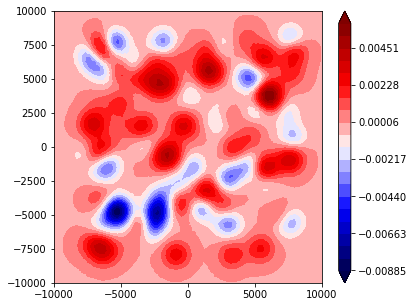

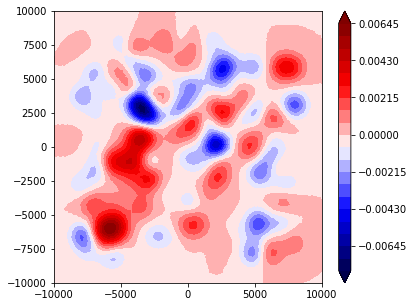

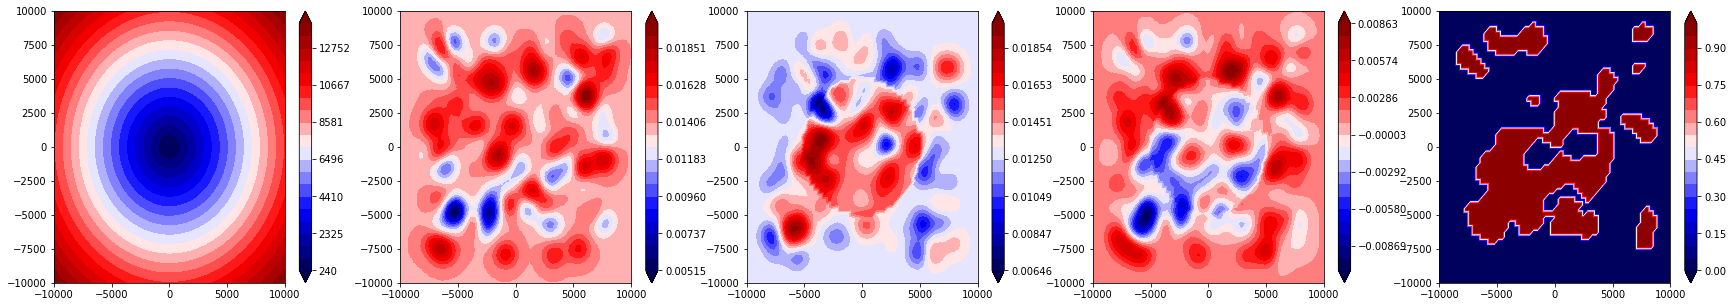

In [3]:
# dof_pts = m[0][m[1]].reshape((-1,3))
# distance_from_center = np.linalg.norm(dof_pts, axis = 1)

# def gen_peaks(n_peaks, amplitude, width):
#     n_peaks = 150
#     centers = (np.random.rand(n_peaks, 2) - 0.5) * 2 * L * 0.8
#     As = (np.random.rand(n_peaks) - 0.5) * 0.007
#     width = 1000
#     r2 = (dof_pts[:,0][:,np.newaxis] - centers[:,0]) ** 2 + (dof_pts[:,2][:,np.newaxis] - centers[:,1]) ** 2
#     -r2 / (width ** 2)
#     Q = np.sum(As * np.exp(-r2 / (width ** 2)), axis = 1)
#     plot_fields(qdm.m, Q)
#     return Q

# lin_dist = L / 2
# lin_slope = 0.02 / L
# b = np.where(distance_from_center < lin_dist, 0.015, 0.013)#-1 * (lin_dist - distance_from_center) * lin_slope + 0.014)
# a = np.ones_like(b) * 0.014
# a += gen_peaks(75, 0.003, 2000)
# b += gen_peaks(75, 0.007, 2000)
# qd_cfg['a'] = a
# qd_cfg['b'] = b
# all_fields = np.vstack((distance_from_center, qd_cfg['a'], qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'] < 0)).T
# plot_fields(qdm.m, all_fields)

Check that the "process zone" and $k_{crit}$ are good. See section 6 in Erickson et al 2014

In [4]:
mesh_L = min(L, W) / n_fault
Lb = qd_cfg['sm'] * qd_cfg['Dc'] / (qd_cfg['additional_normal_stress'] * qd_cfg['b'])
hstar = (np.pi * qd_cfg['sm'] * qd_cfg['Dc']) / (qd_cfg['additional_normal_stress'] * (qd_cfg['b'] - qd_cfg['a']))
# all_fields = np.vstack((Lb, hstar, np.ones_like(hstar) * mesh_L)).T
# plot_fields(qdm.m, all_fields)
np.min(np.abs(hstar)), np.min(Lb), mesh_L

(2219.657938205014, 377.1639065293412, 166.66666666666666)

Setup the (slip -> traction) operator

Set up initial conditions. The edges of the fault should move at the plate rate and the interior should be moving at 1/1000th the plate rate. Then, solve for the corresponding steady state.

In [ ]:
def get_traction_to_slip(qdm, qd_cfg):
    tectosaur.logger.setLevel(qd_cfg['tectosaur_cfg']['log_level'])
    cs2 = continuity_constraints(qdm.m.get_tris('fault'), np.array([]))
    cm2, c_rhs2 = build_constraint_matrix(cs2, qdm.m.n_dofs('fault'))
    hypersingular_op = make_integral_op(qdm.m, 'elasticH3', [qd_cfg['sm'], qd_cfg['pr']], qd_cfg['tectosaur_cfg'], 'fault', 'fault')
    traction_mass_op = make_mass_op(qdm.m, qd_cfg['tectosaur_cfg'])
    constrained_traction_mass_op = cm2.T.dot(traction_mass_op.mat.dot(cm2))
    def traction_to_slip(slip):
        rhs = constrained_traction_mass_op()
        rhs = hypersingular_op.dot(slip)
        #return spsolve(traction_mass_op.mat, rhs)
        out = cm2.dot(spsolve(constrained_traction_mass_op, cm2.T.dot(rhs)))
        return out
    return slip_to_traction

In [5]:
# def steady_state(V_mag):
#     # This could just be analytically solved, but why not just do it numerically...
#     def f(state):
#         return aging_law(qd_cfg, V_mag, state)
#     return fsolve(f, 0.0, maxfev = 10000)
initial_state = 0.8 * np.ones(qdm.m.tris.shape[0] * 3)

In [6]:
initial_state

array([ 0.8,  0.8,  0.8, ...,  0.8,  0.8,  0.8])

In [7]:
slip_to_traction = get_slip_to_traction(qdm, qd_cfg)
derivs = make_qd_derivs(qdm, qd_cfg, slip_to_traction)

[76168:INFO:tectosaur.util.cuda]
    Initialized CUDA on gpu: 0


In [8]:
initial_conditions = np.concatenate((np.zeros(qdm.m.n_dofs()), initial_state))
integrator = RK45(derivs, 0, initial_conditions, 1e20, atol = 1e-5, rtol = 1e-5)

0 1.24722911412e-07
V


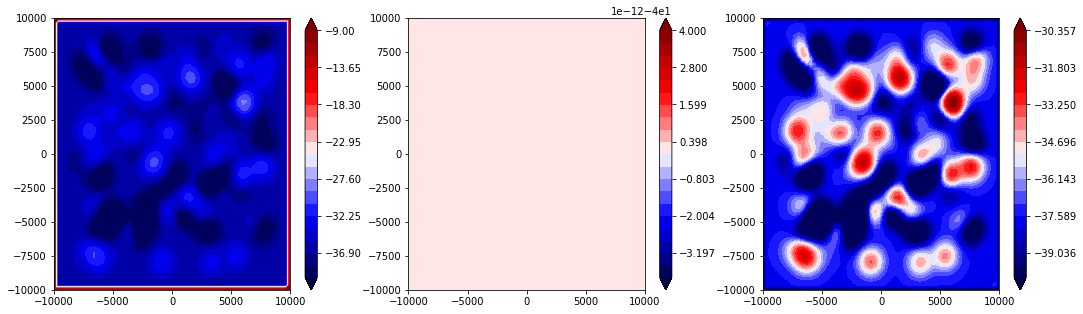

traction


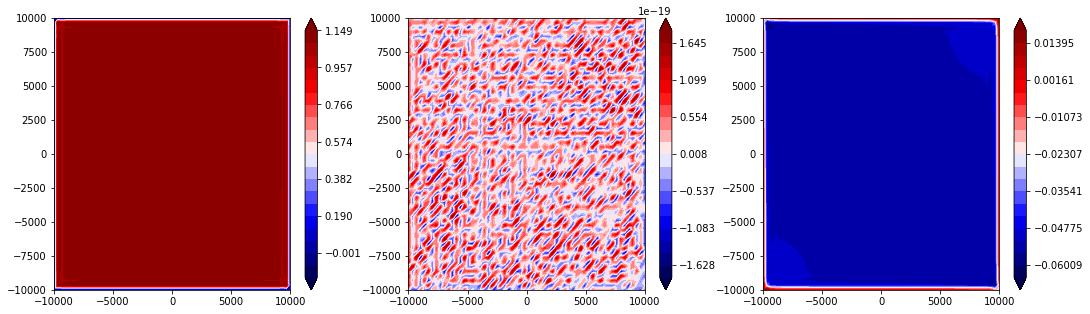

state


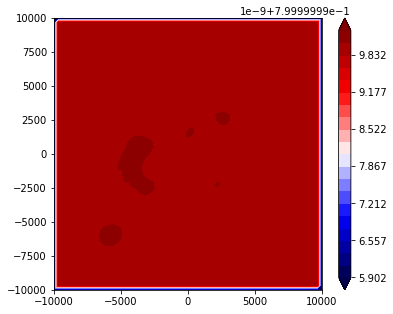

1 1.37195202553e-06
2 1.38442431667e-05
3 0.000138567154578
4 0.0013857962687
5 0.0138580874099
6 0.138580998822
7 1.38581011294
8 2.40278708603
9 2.93391884513


/home/tthompson/Dropbox/projects/qd/notebooks/qd_helpers.py:127: RuntimeWarning: overflow encountered in exp
  np.exp((qd_cfg['f0'] - state) / qd_cfg['b']) - (V / qd_cfg['V0'])
/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:141: RuntimeWarning: invalid value encountered in true_divide
  error_norm = norm(error / scale)


10 3.3245631423
V


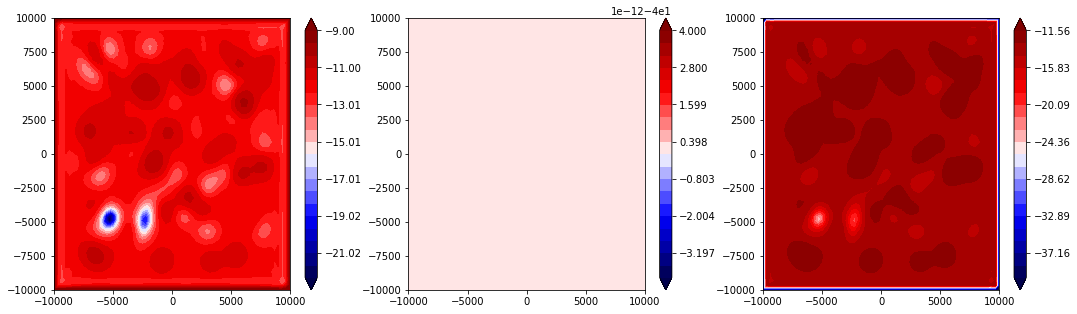

traction


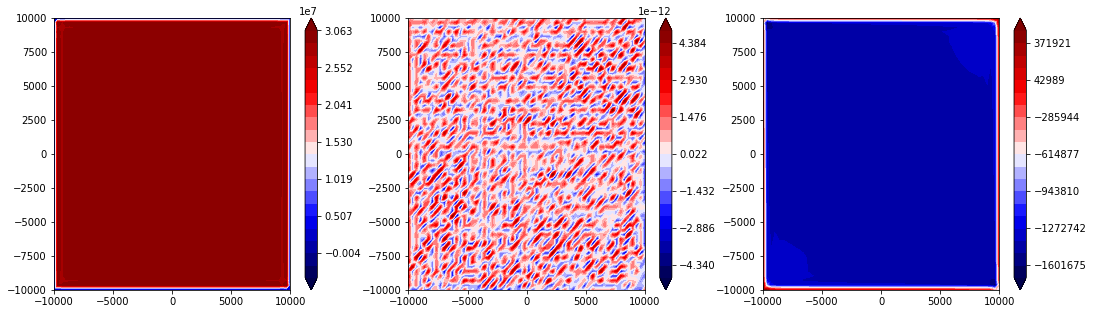

state


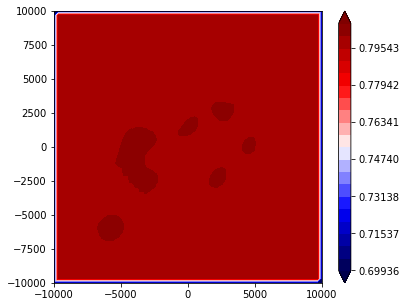

11 3.55110697
12 3.66470288702
13 3.74894561408
14 3.81216739289
15 3.86130023557
16 3.95120397865
17 4.0467693909
18 4.14557793857
19 4.17362597668
20 4.20485413538
V


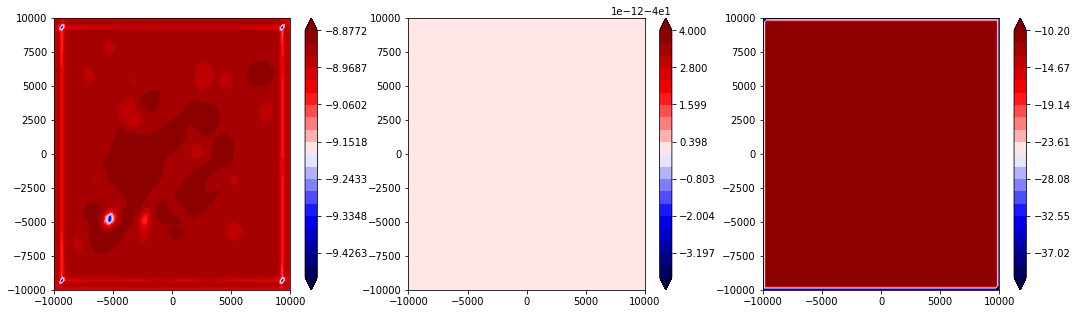

traction


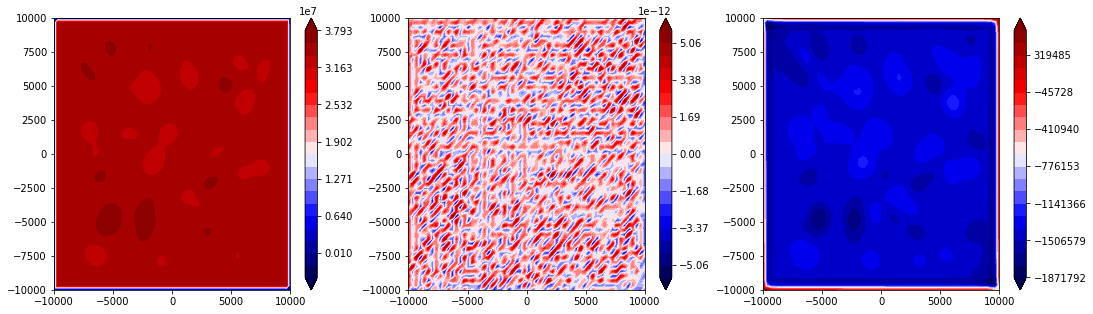

state


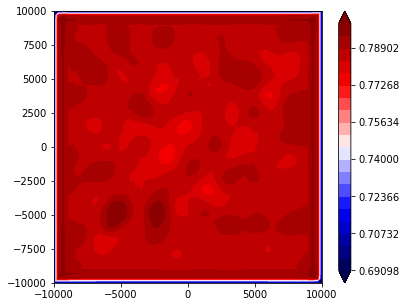

21 4.23566096022
22 4.26558527645
23 4.29473890497
24 4.32371994257
25 4.35402914921
26 4.42270889389
27 4.61306939581
28 4.65114149619
29 4.67912174502
30 4.70832743518
V


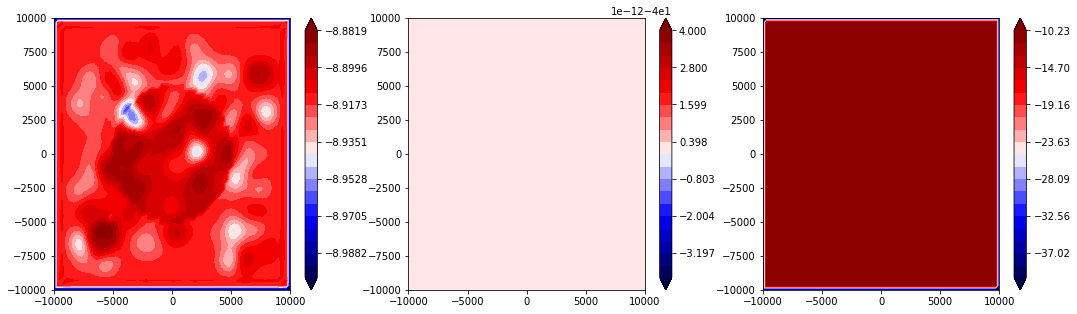

traction


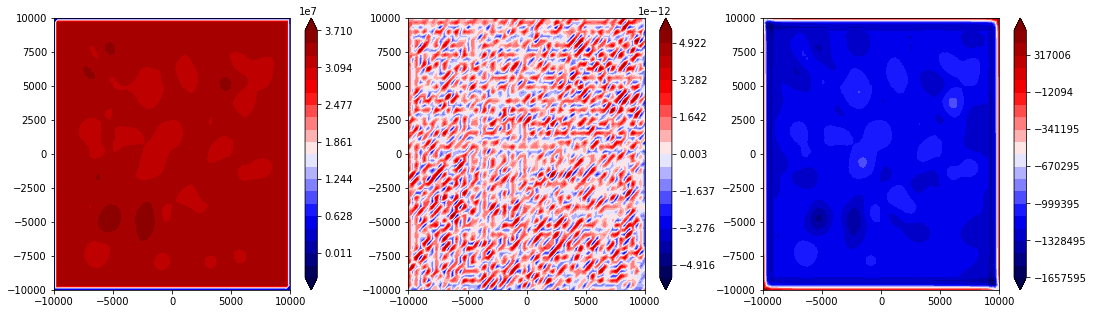

state


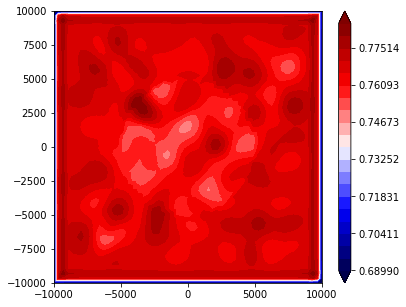

31 4.73939942888
32 4.85048114846
33 4.88724792456
34 4.99384421749
35 5.03250901239
36 5.16266094089
37 5.20198519615
38 5.24136200092
39 5.41604685809
40 5.45098382953
V


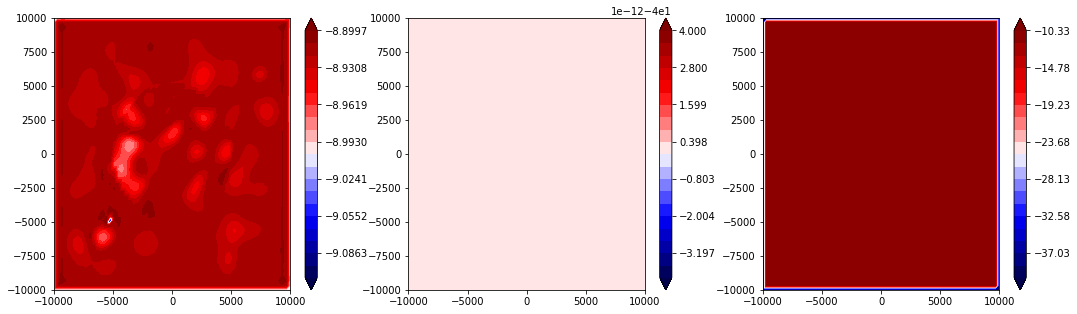

traction


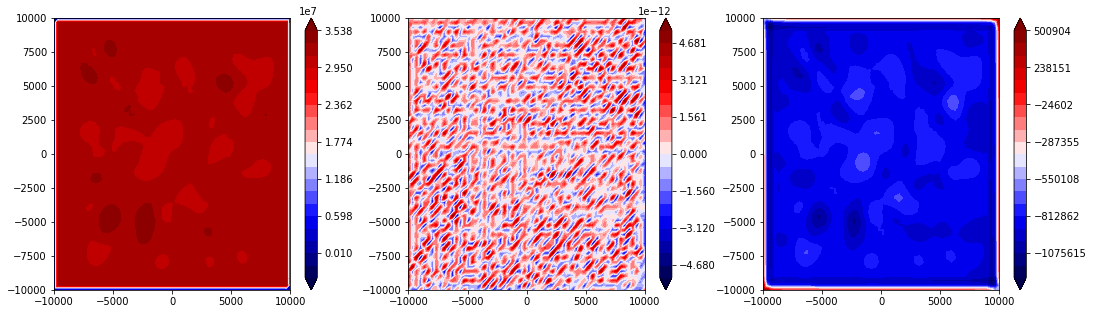

state


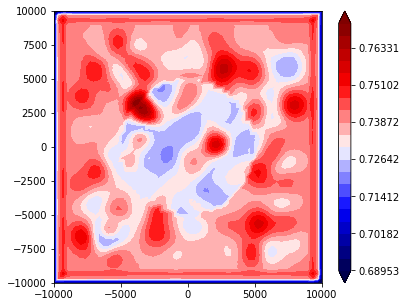

41 5.47821811888
42 5.50409539068
43 5.52892275543
44 5.60850953931
45 5.74242831758
46 5.7771980401
47 5.80771114156
48 5.90516612511
49 5.94043910088
50 6.10526195057
V


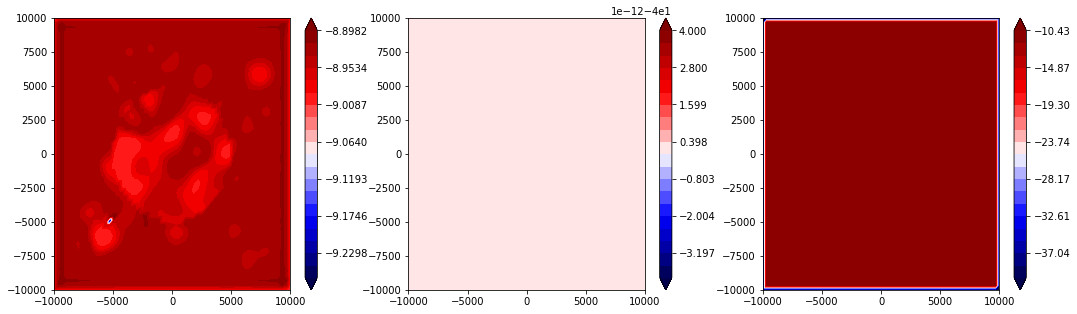

traction


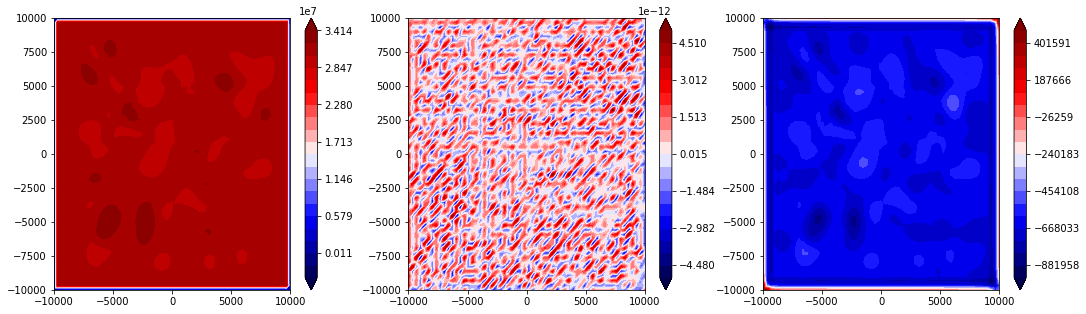

state


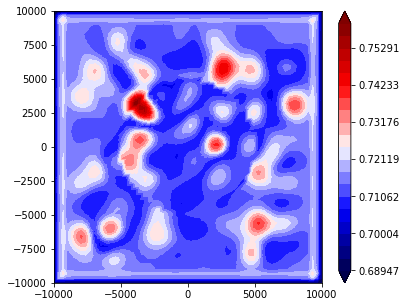

51 6.13933928479


/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:141: RuntimeWarning: overflow encountered in true_divide
  error_norm = norm(error / scale)


52 6.17115753371
53 6.20357489943
54 6.23741062571
55 6.27504732309
56 6.40679796092
57 6.45505171849
58 6.59121511948
59 6.6448973085
60 6.83242429086
V


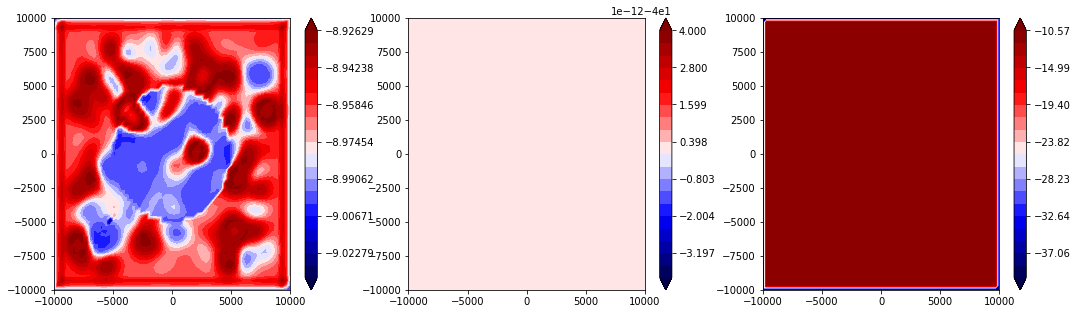

traction


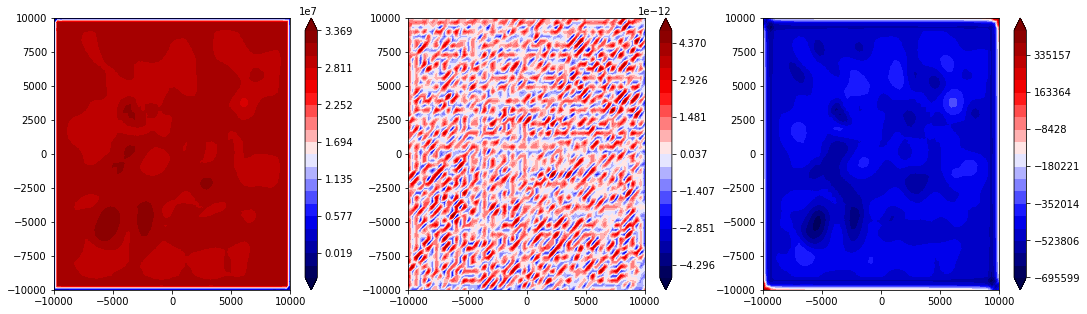

state


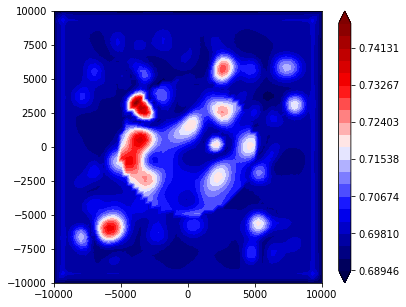

61 6.88630661493
62 6.92655474351
63 7.0573065835
64 7.10976432456
65 7.29890145966
66 7.35306385895
67 7.39643290307
68 7.53412731868
69 7.59366753298
70 7.81671727502
V


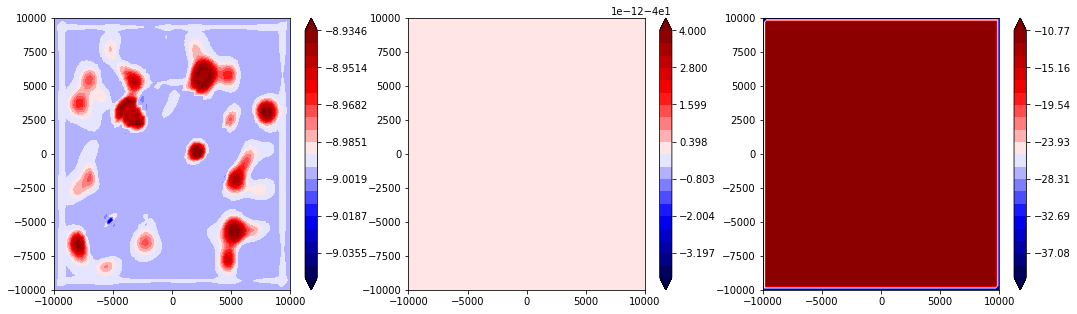

traction


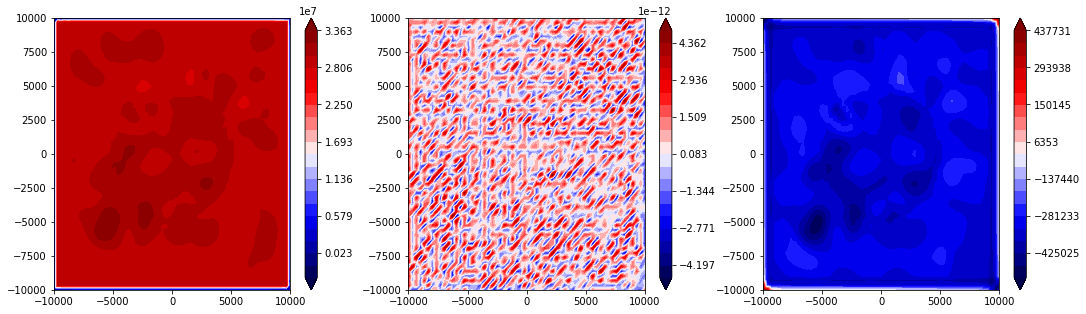

state


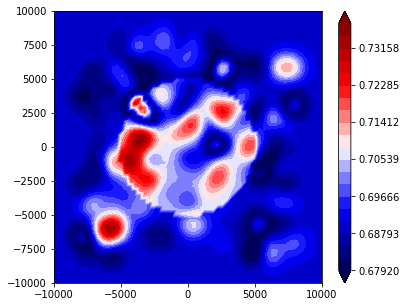

71 7.88032778393
72 7.93139412
73 7.98540245855
74 8.20515980413
75 8.27247499538
76 8.39809632438
77 8.44744864093
78 8.52267821672
79 8.82695318167
80 8.89446264188
V


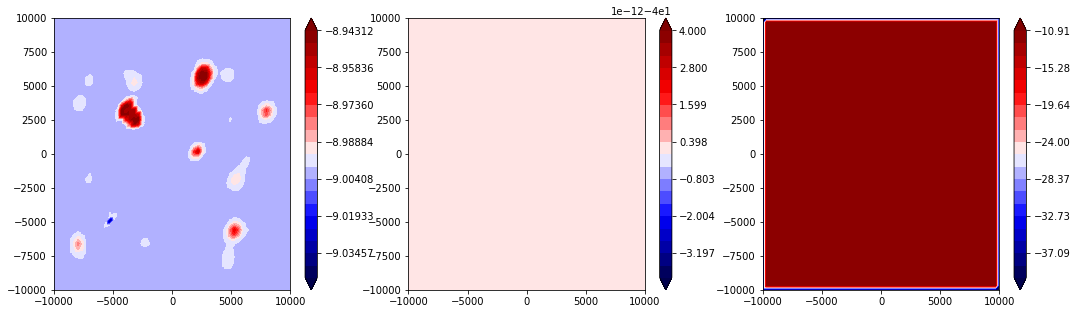

traction


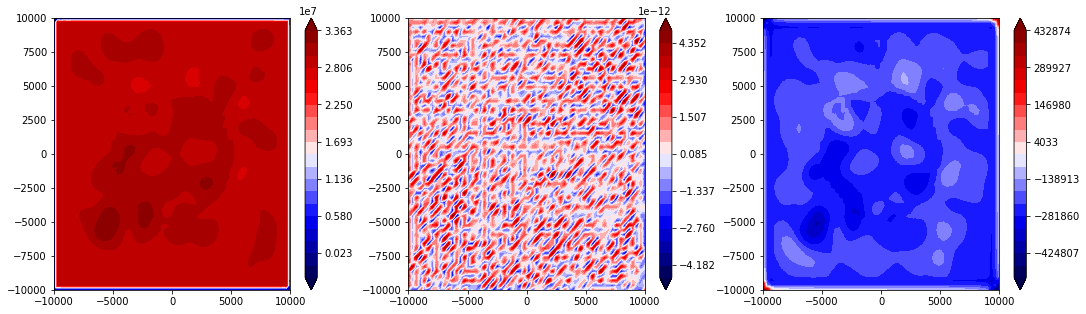

state


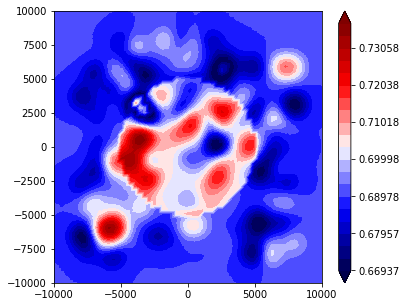

81 8.92791860718
82 8.97212270242
83 9.02150996835
84 9.08064565203
85 9.3316155288
86 9.40559646739
87 9.54399244993
88 9.58957350491
89 9.63770796908
90 9.69677433745
V


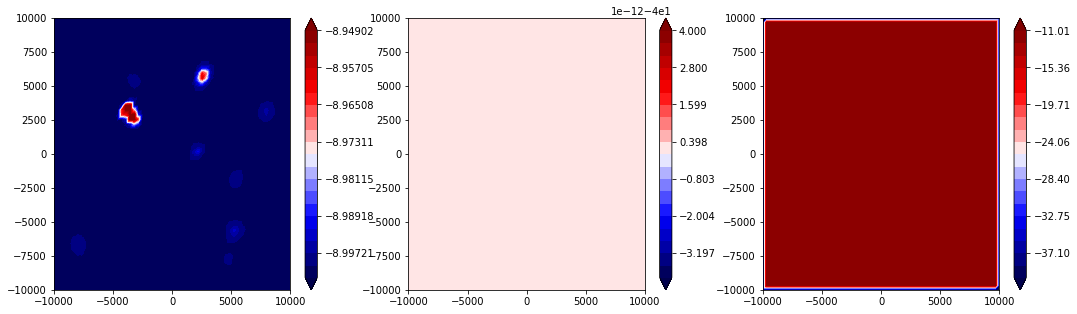

traction


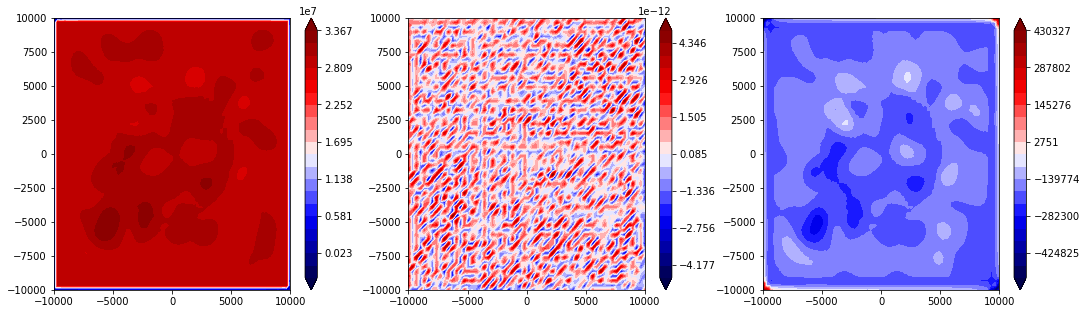

state


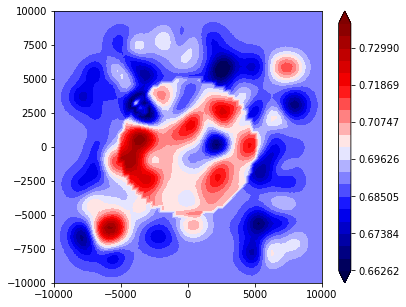

91 9.94468223244
92 10.0165963435
93 10.1452147359
94 10.1908504009
95 10.2428551561
96 10.4023047214
97 10.4713293093
98 10.7013792115
99 10.7625986174
100 10.7999051638
V


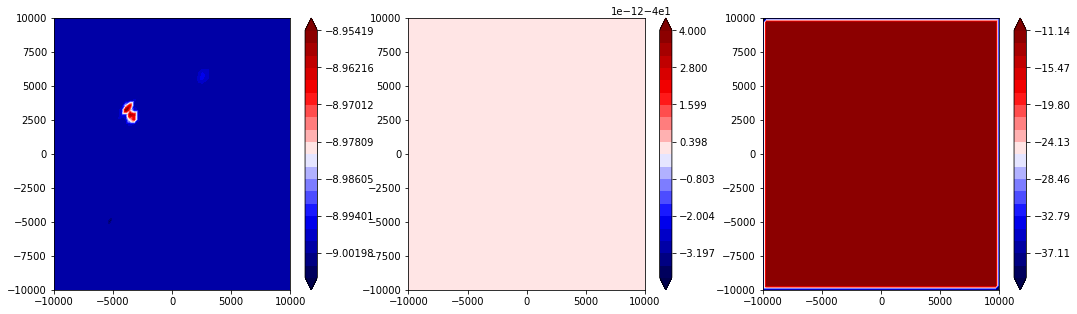

traction


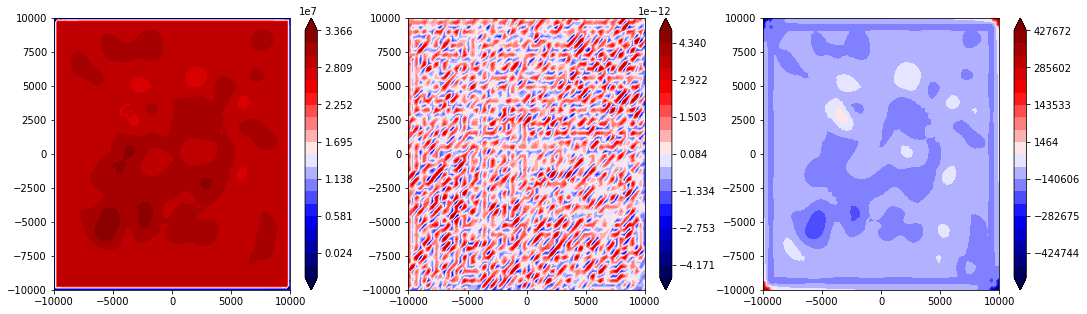

state


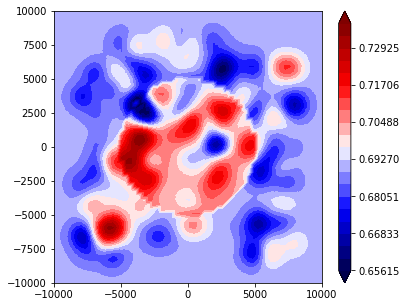

101 10.8511282525
102 10.9100994752
103 11.1593053811
104 11.2336786884
105 11.3776188735
106 11.4226431528
107 11.4682515903
108 11.5244097026
109 11.7145224413
110 11.7864942561
V


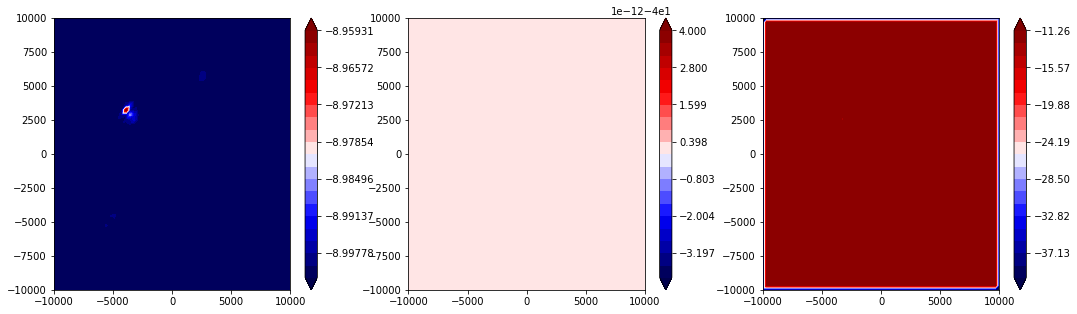

traction


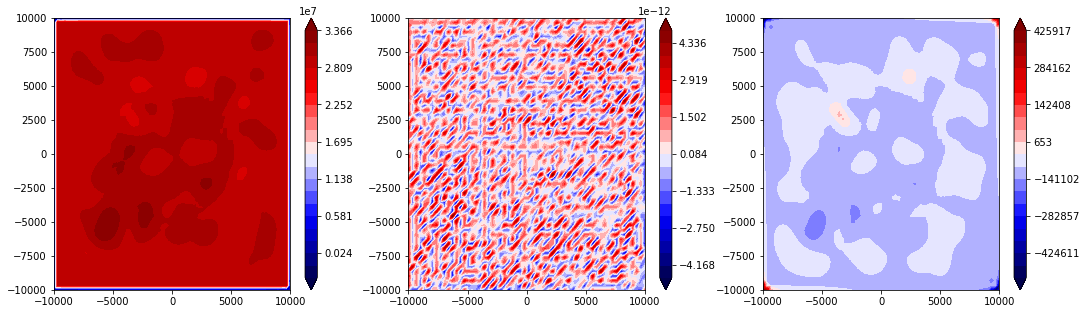

state


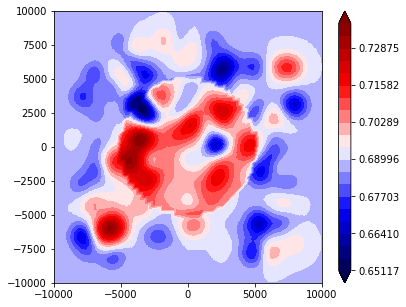

111 11.987561179
112 12.0413802662
113 12.080145938
114 12.1296178695
115 12.1874734599
116 12.4133754117
117 12.4880631962
118 12.6567786673
119 12.7049701687
120 12.7465789756
V


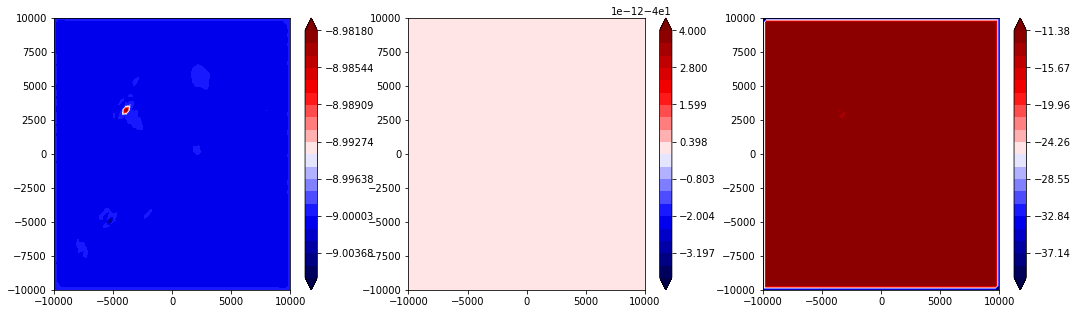

traction


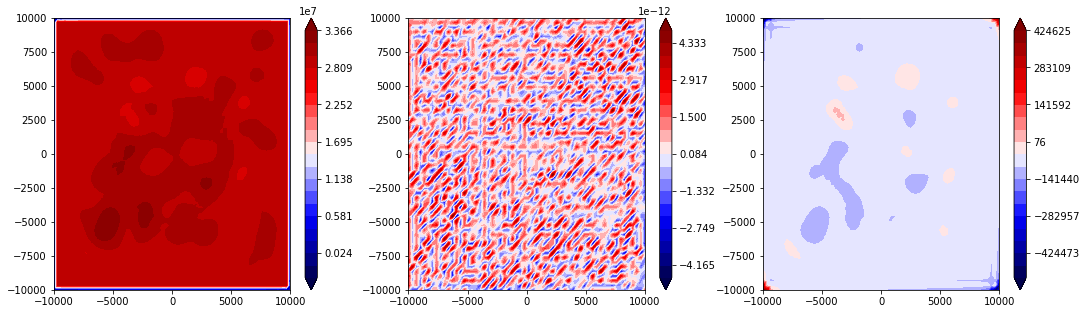

state


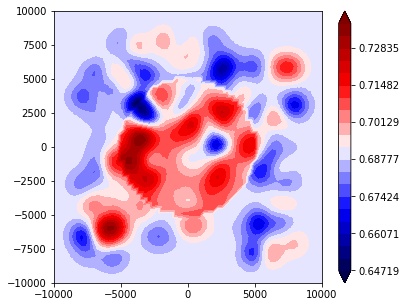

121 12.7976530592
122 12.8592490223
123 13.1279822681
124 13.2034120807
125 13.3340732493
126 13.3776575823
127 13.4268417185
128 13.4865516417
129 13.732261571
130 13.8069913798
V


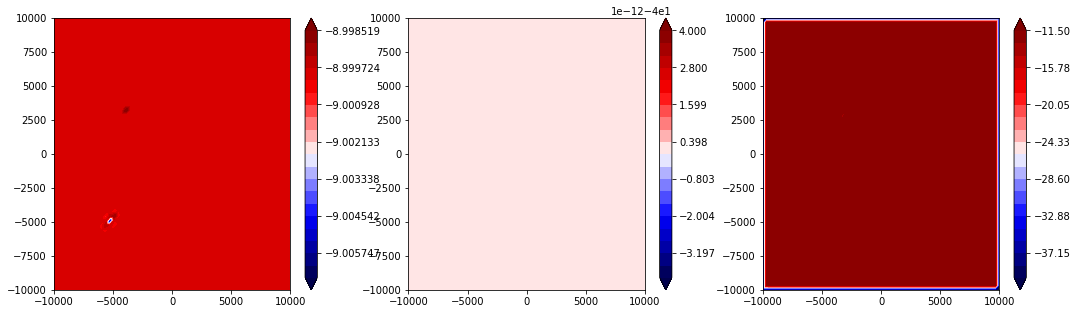

traction


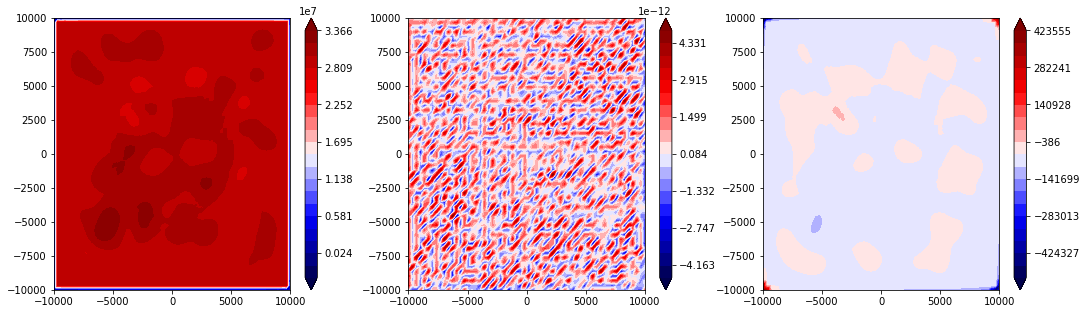

state


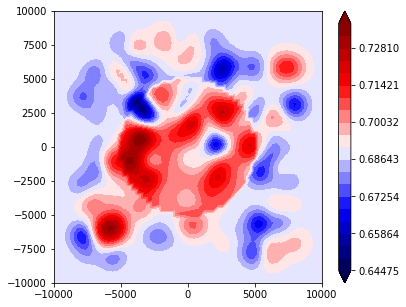

131 13.9534283218
132 13.9991319818


In [ ]:
from tectosaur.util.timer import Timer
h_t = []
h_y = []
siay = 60 * 60 * 24 * 365.25
for i in range(10000):
    assert(integrator.step() == None)
    h_t.append(integrator.t)
    h_y.append(integrator.y.copy())
    print(i, integrator.t / siay)
    if i % 10 == 0:
        plot_setting(integrator.t, integrator.y, qdm, qd_cfg, slip_to_traction)
    if i % 200 == 0:
        np.save('results.npy', np.array([qdm.m, qd_cfg, h_t, h_y], dtype = np.object))